# **# XGBoost Detective for Book Purchase Prediction Engine (Demo Version - Classification)**

(**Note:** Due to client NDA restrictions, the original dataset is not included. File paths and dataset names are placeholders intended to demonstrate the modeling workflow. While the demo project below excludes certain analyses associated with the original work, I have tried my best to mirror the modeling workflow.)

## Problem Statement
The company was experiencing declining book sales and needed a data-driven way to identify customers most likely to make a purchase. The goal was to leverage historical customer behavior and demographic attributes to predict purchase intent and enable proactive outreach.

## Business Objective
Develop a classification model to identify high-probability buyers for focused, data-driven marketing campaigns, improving conversion rates while reducing wasted marketing spend.

## Data Description
The dataset consists of approximately [~90k] customer records, including demographic attributes, engagement metrics, and historical purchase behavior used to predict purchase likelihood.

## Approach
- Data cleaning and preprocessing
- Exploratory data analysis to understand class distribution
- Feature selection and engineering
- Model development using multiple classification algorithms
- Model evaluation using cross-validation and classification metrics
- Interpretation of key drivers influencing purchase decisions

## Key Results (XGBoost)
The selected model achieved strong predictive performance with balanced precision and recall, indicating reliable customer targeting capability.

- **Accuracy**: ~[93]
- **Precision**: ~[90]
- **Recall**: ~[96]
- **F1-Score**: ~[93]
- **ROC-AUC**: ~[96]

## Business Impact
- Provides a data-driven framework to prioritize customers with higher purchase intent for marketing outreach.
- Increases campaign effectiveness by aligning messaging and timing with customers most likely to convert.
- Reduces marketing inefficiencies by minimizing spend on low-response segments and improving overall ROI.

## Note:
- This notebook demonstrates the methodology for a purchase prediction model.

- Data and visuals are anonymized for confidentiality. The dataset used in training is imitation of a proprietary dataset that is protected under NDA.

- All metrics and plots are reproduced from the dataset for illustration purposes.

- Metrics are rounded/sanitized due to client confidentiality.

**Data Loading & Initial Setup**

In [ ]:
# Importing Required Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve, average_precision_score)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from xgboost import plot_tree, plot_importance
from IPython.display import display
from math import pi
import shap
from sklearn.inspection import permutation_importance

In [ ]:
# Importing Required Files
df = pd.read_csv("data/example_dataset.csv")  # placeholder

**Data Cleaning & Preprocessing**

In [ ]:
# Standardizing Column Names (Removing Whitespace)
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_')
df = df.loc[:, ~df.columns.duplicated()]

# Assessing Duplicate Rows
df.duplicated().sum().sum()

np.int64(0)

In [ ]:
# Checking for Constant or Duplicate Columns
nunique = df.nunique()
print("Constant columns:", nunique[nunique == 1].index.tolist())

Constant columns: []


In [ ]:
# Handling List Values in 'preferred_genres' Column
df['preferred_genres'] = df['preferred_genres'].str.replace(' ', '')

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df['preferred_genres'].str.split(','))
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
df = pd.concat([df, genres_df], axis=1)

In [ ]:
# Dropping Irrelevant Columns
df.drop(columns=['user_id', 'book_id', 'preferred_genres'],inplace=True)

**Feature Encoding & Engineering**

In [ ]:
# Label Encoding for Categorical Features
cat_features=df[['title', 'author','gender','location', 'genre','sub_genre', 'language', 'series']]
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in cat_features:
    df[col]=le.fit_transform(df[col])

In [ ]:
# Feature Engineering
df['genre_age'] = df['genre'] * df['age']
df['price_membership_duration'] = df['price'] * df['membership_duration']
df['wishlist_cart_ratio'] = df['added_to_wishlist'] / (df['added_to_cart'] + 1)
df['click_rate'] = df['clicks_on_book'] / (df['time_spent_on_book_page'] + 1)
df['price_per_page'] = df['price'] / (df['page_count'] + 1)
df['user_value_index'] = df['average_rating'] * df['books_read_count']
df['engagement_score'] = (df['clicks_on_book'] + df['added_to_wishlist'] + df['added_to_cart']) * df['time_spent_on_book_page']
df['time_rating']=df['time_spent_on_book_page'] * df['user_rating']
df['wish_click']=df['added_to_wishlist']*df['clicks_on_book']
df['rating_title']=df['average_rating']*df['title']

**Data Preparation for Modeling**

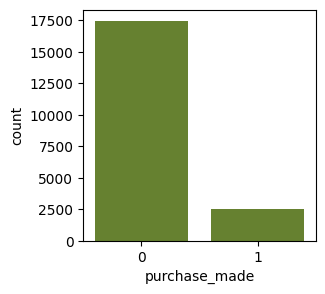

In [ ]:
# Defining Features (X) and Target Variable (y)
x = df.drop (columns = ['purchase_made'])
y = df ['purchase_made']

# Target Variable Distribution (Count Plot)
plt.figure(figsize=(3,3))
sns.countplot(x='purchase_made', data=df, color='olivedrab')
plt.show()

In [ ]:
# Handling Class Imbalance Using Random Oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler (sampling_strategy = 'minority', random_state=42)
x_resampled, y_resampled = ros.fit_resample(x, y)

In [ ]:
# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(
    x_resampled, y_resampled, test_size=0.3, random_state=42)

**Model Development**

In [ ]:
# Defining ML Models
models = {
    "LGBM": LGBMClassifier(random_state=42),
    "XGB": XGBClassifier(eval_metric='logloss', verbosity=0, random_state=42)}

In [ ]:
# Defining Hyperparameters
params = {
    "LGBM": {"n_estimators": [100, 300, 500], "max_depth": [3, 5, 7], "learning_rate": [0.05, 0.1, 0.2], "subsample": [0.8, 1.0], "colsample_bytree": [0.8, 1.0]},
    "XGB": {"n_estimators": [100, 300, 500], "max_depth": [3, 5, 7], "learning_rate": [0.05, 0.1, 0.2], "subsample": [0.8, 1.0], "colsample_bytree": [0.8, 1.0]}}


In [ ]:
# Hyperparameter Tuning

tuned = {}

for name in models:
    search = RandomizedSearchCV(estimator=models[name],param_distributions=params[name],n_iter=5,cv=3,scoring="accuracy",n_jobs=-1,random_state=42)
    search.fit(x_train, y_train)
    tuned[name] = search.best_estimator_
    print(name, search.best_params_)

**Model Evaluation & Comparison**

In [ ]:
# Model Performance Results

from sklearn.metrics import roc_auc_score

results = {}

for name, model in tuned.items():
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:, 1]

    results[name] = {
        "train_acc": accuracy_score(y_train, y_pred_train),
        "test_acc":  accuracy_score(y_test, y_pred_test),
        "roc_auc":   roc_auc_score(y_test, y_prob),
        "auc_pr":    average_precision_score(y_test, y_prob)}

    print( f"\n{name} — Train Accuracy: {results[name]['train_acc']:.4f}, " f"Test Accuracy: {results[name]['test_acc']:.4f}, " f"AUC: {results[name]['roc_auc']:.4f}, " f"AUC_PR: {results[name]['auc_pr']:.4f}," )

## Model Performance Summary (for real project)

| Model Name              | CV Method | Accuracy | Precision | Recall | F1-Score | ROC-AUC |
|-------------------------|-----------|----------|-----------|--------|----------|---------|
| XGBoost     | 5-Fold CV | [~93]   | [~90]    | [~96] | [~93]   | [~96]  |
| LightGBM   | 5-Fold CV | [~90]   | [~87]    | [~92] | [~90]   | [~93]  |

**Evaluation Notes**
- Metrics are mean scores from 5-fold cross-validation.
- Model selection prioritized recall and ROC-AUC to minimize missed potential buyers.

In [ ]:
# Model Ranking by Test Accuracy (Bar Chart)

df_results = pd.DataFrame(results).T

ranking = df_results.sort_values("test_acc", ascending=False)

df_results["test_acc"].sort_values().plot.barh(figsize=(4,4), color='darkslateblue')
plt.title("Model Ranking by Test Accuracy")
plt.xlabel("Accuracy")
plt.tight_layout()
plt.show()

## Final Model Selected & Rationale
The XGBoost classifier was selected as the final model due to its superior recall and ROC-AUC performance, indicating strong capability in identifying potential buyers while maintaining acceptable precision. This balance makes it well-suited for customer targeting and prioritization use cases.

In [ ]:
# Identifying the Best Model

best_name = max(results, key=lambda m: results[m]["test_acc"])
best_model = tuned[best_name]
print("\nBest model:", best_name)


Best model: XGB


**Model Performance Analysis**

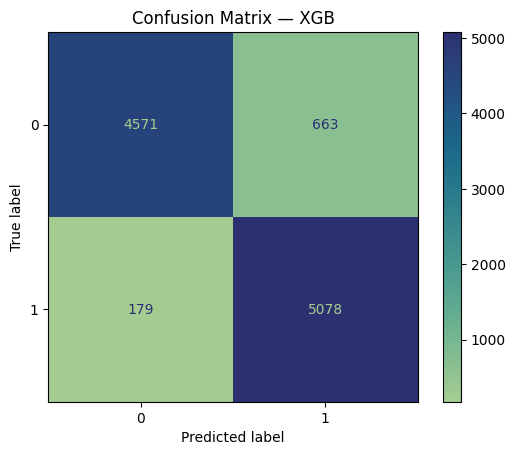

In [ ]:
# Confusion Matrix

y_pred = best_model.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="crest", values_format='d')
plt.title(f"Confusion Matrix — {best_name}")
plt.show()

In [ ]:
# Classification Report

print(f"Classification Report — {best_name}\n")
print(classification_report(y_test, y_pred))

Classification Report — XGB

              precision    recall  f1-score   support

           0       0.96      0.87      0.92      5234
           1       0.88      0.97      0.92      5257

    accuracy                           0.92     10491
   macro avg       0.92      0.92      0.92     10491
weighted avg       0.92      0.92      0.92     10491



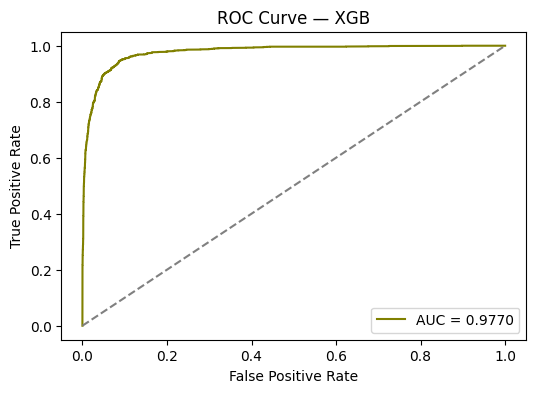

In [ ]:
# ROC Curve + AUC

from sklearn.metrics import roc_curve, roc_auc_score

y_prob = best_model.predict_proba(x_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='olive', label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve — {best_name}")
plt.legend()
plt.show()

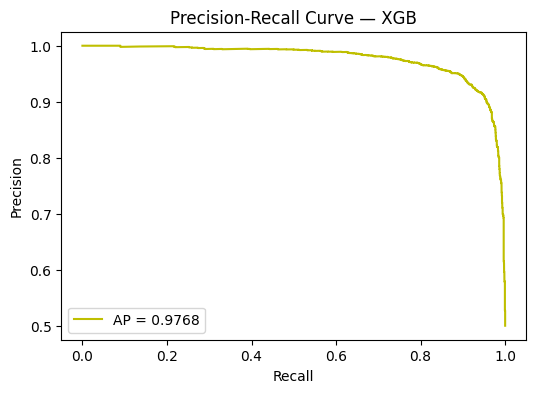

In [ ]:
# Precision-Recall (PR) Curve + AUC

precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, color='y', label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve — {best_name}")
plt.legend()
plt.show()

**Model Interpretation & Explainability**

## Key Drivers of Purchase Decision
The following features were identified as the most influential factors affecting customer purchase behavior. These insights can directly support marketing strategy and customer segmentation efforts.
- Customer tenure on the platform
- Indicators of wishlist and cart engagement
- User interaction intensity with product pages
- Combined engagement and feedback signals
- Genre-level preference patterns
- Repeat engagement with related product collections

/tmp/ipython-input-3386299933.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(feat_imp, palette='cividis')


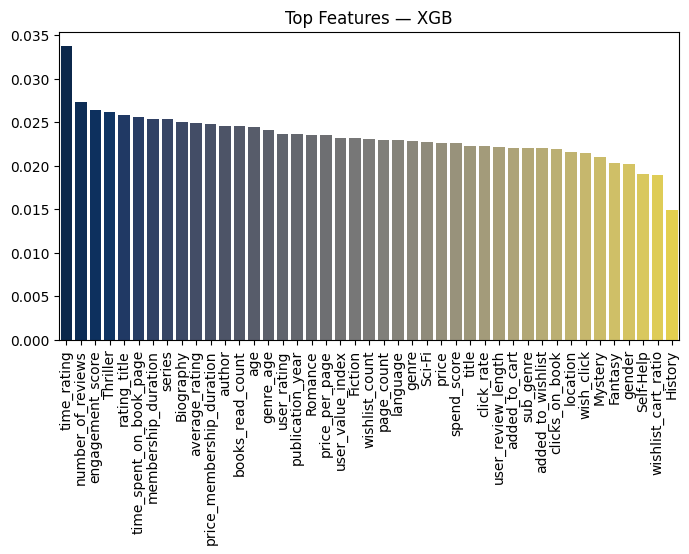

In [ ]:
# “Key Drivers of Purchase Decision” (Feature Importance Analysis)

feat_imp = pd.Series(best_model.feature_importances_, index=x_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(feat_imp, palette='cividis')
plt.title(f"Top Features — {best_name}")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Top-K Feature Selection and Model Retraining

from sklearn.base import clone

k = 27  # select top k features
top_features = feat_imp.head(k).index

x_train_k = x_train[top_features]
x_test_k = x_test[top_features]

# Clone and retrain the model on top k features
best_model_k = clone(best_model)
best_model_k.fit(x_train_k, y_train)

# Evaluate
y_pred_k = best_model_k.predict(x_test_k)
accuracy_k=accuracy_score(y_test, y_pred_k)

100%|===================| 10489/10491 [02:59<00:00]       

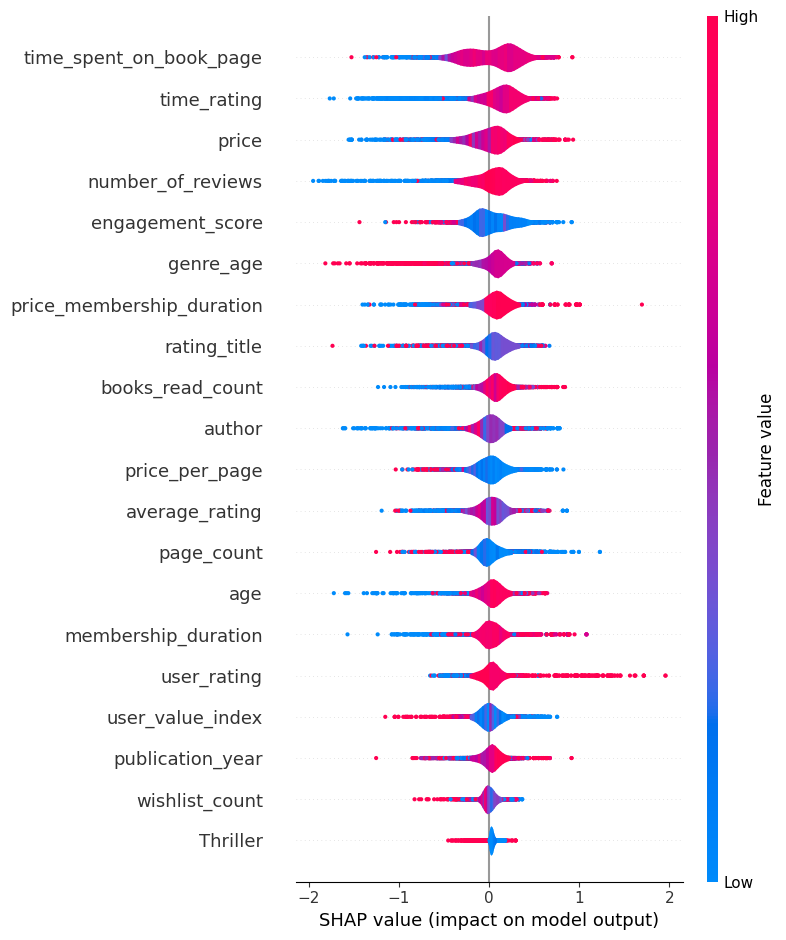

In [ ]:
# SHAP Value Analysis

explainer = shap.Explainer(best_model_k, x_train_k)
shap_values = explainer(x_test_k)
shap.summary_plot(shap_values, x_test_k, plot_type="violin")

/tmp/ipython-input-2074236280.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(perm_feat_imp, palette='Set1')


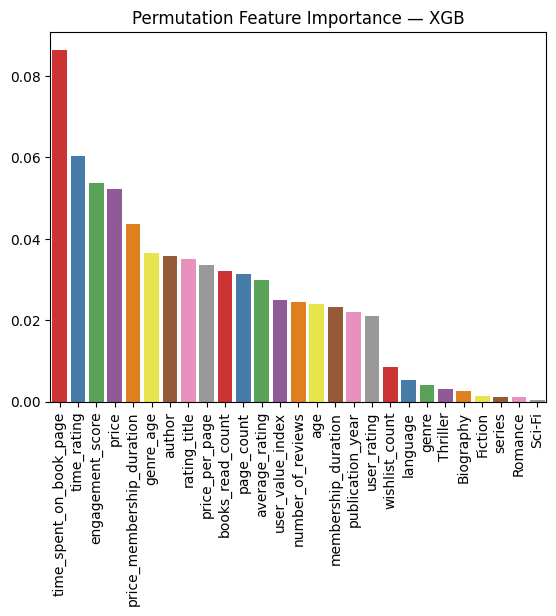

In [ ]:
# Permutation Importance

perm_imp = permutation_importance(best_model_k, x_test_k, y_test, n_repeats=10, random_state=42)
perm_feat_imp = pd.Series(perm_imp.importances_mean, index=top_features).sort_values(ascending=False)

# Plot
sns.barplot(perm_feat_imp, palette='Set1')
plt.title(f"Permutation Feature Importance — {best_name}")
plt.xticks(rotation=90)
plt.show()

**Model Persistence**

In [ ]:
# Saving the Best Model
import pickle

with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

## Final Model Chosen & Why
The XGBoost classifier was selected as the final model due to its superior performance, particularly its higher recall and ROC-AUC. This indicates effective identification of potential buyers while maintaining acceptable precision.

From a business standpoint, prioritizing recall ensures that high-value customers are not missed, making the model suitable for targeted marketing and customer acquisition strategies.


## Business Interpretation
- High recall ensures potential buyers are not missed
- Balanced precision controls marketing costs
- ROC-AUC indicates strong ranking capability for customer prioritization

## Limitations
- Model performance depends on data quality and historical behavior patterns.
- Limited feature availability may restrict predictive power.
- Not tested on real-time streaming data.

## Next Steps (Production / Business)
- Deploy the model as a batch scoring pipeline for marketing campaigns.
- Monitor model performance and retrain periodically.
- Enhance the model with additional behavioral and transactional features.